# Hierarchical storage formats

In the fundamentals section we saw that xarray can read and write to a variety of storage formats. We have also seen that xarray's data model can include a hierarchy of groups as part of an `xarray.DataTree` object.

The design of each format makes certain choices, and here we will compare the structure of common data formats to xarray's full data model, concentrating on subtle differences.

## Xarray is not a file format

You sometimes hear people say things like "save it as an xarray". This does not make sense, because xarray is not a file-format, it is an in-memory data structure. It's analogous to the difference between a CSV file and a `pandas.DataFrame`.

Xarray data structures were inspired by scientific file formats (particularly netCDF), but are not intended to be identical to any of them. This helps xarray be a completely domain-agnostic tool. 

Xarray supports reading from and writing to a range of file formats, but as common file formats have differences in their design, xarray data structures cannot be exactly equivalent to all of them.

Overall though this makes sense because the use case is different: in-memory data is for analysis, on-disk data is for persistent storage.

## Groups everywhere

Many storage formats for scientific data include some notion of "groups". 

The exact meaning of "group" differs between formats but  are all ultimately motivated by a common recognition: that real scientific datasets often include related but otherwise heterogenous data.

## Zarr

We'll start with Zarr, because it has the most simple type of heirarchical structure.

- Tree of arbitrary groups
- Each holds arbitrary data in the form of arrays + metadata
- No relationship enforced between groups
- No relationship enforced between arrays within a group
- No concept of "coordinates" vs "data"
- No references from one group to another

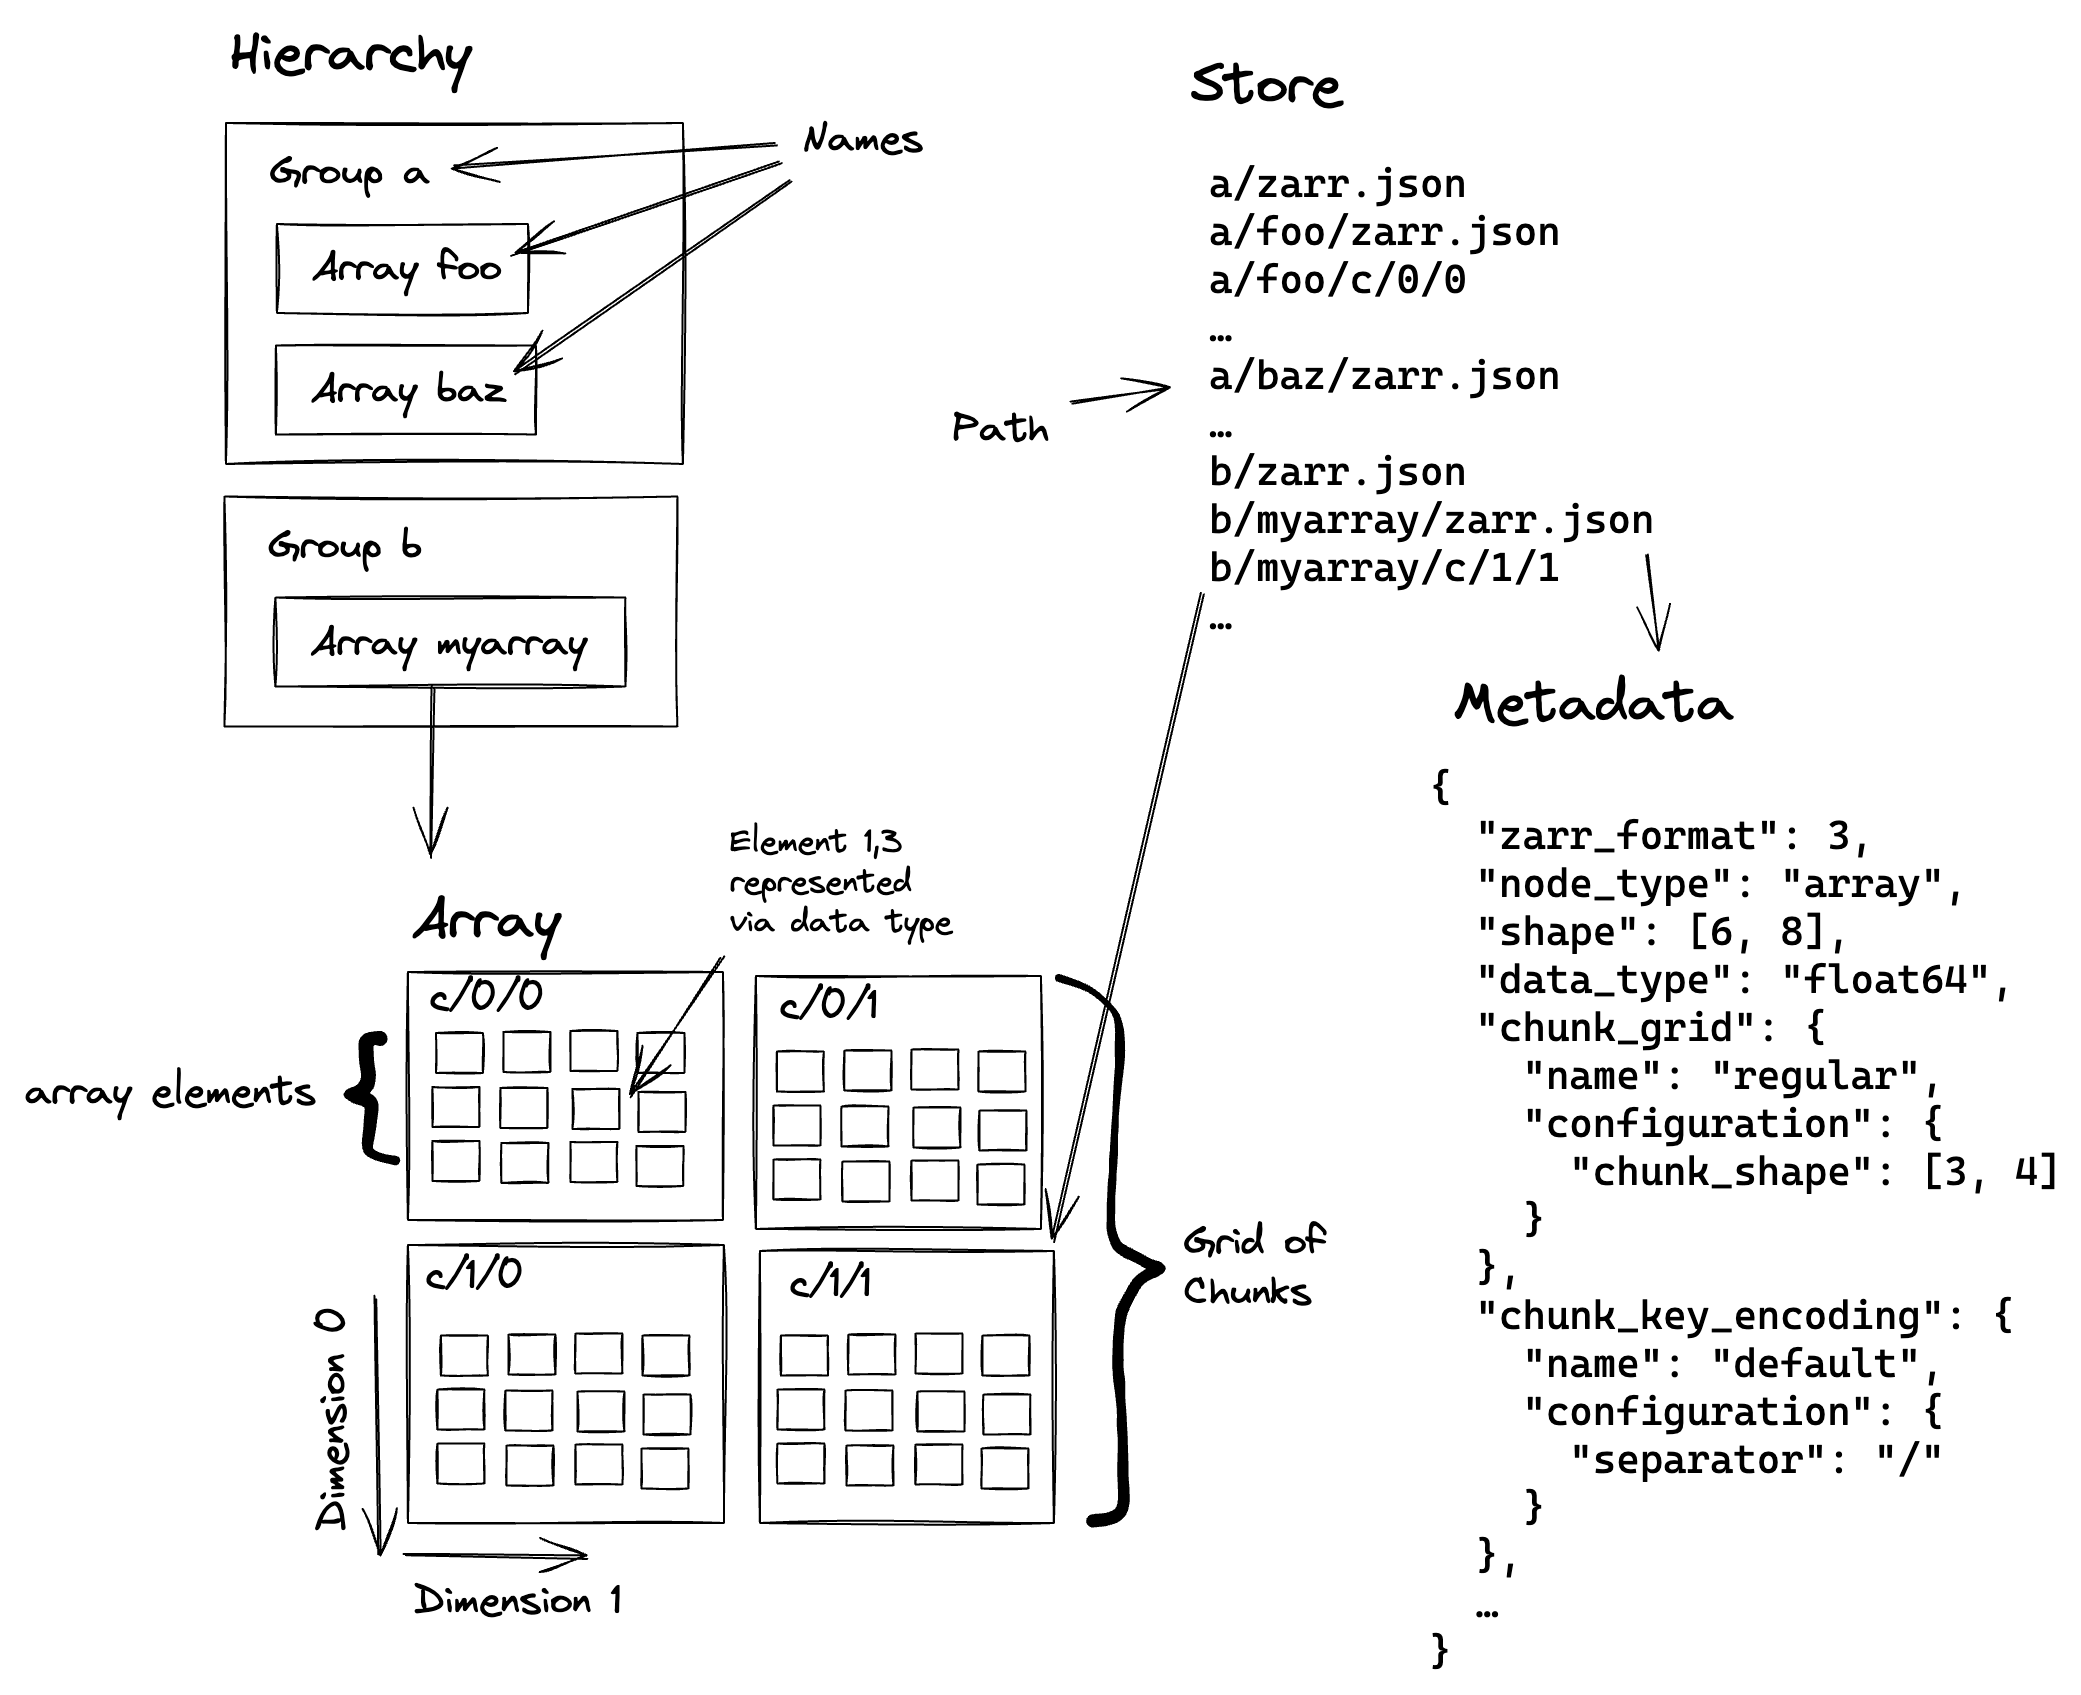

How does zarr relate to `xarray`?

- zarr arrays map well to `xarray.Variables`
  - especially because zarr v3 includes (optional) `dimension_names`
- zarr groups map reasonably well to `xarray.Dataset` objects
  - `xr.open_dataset(store, group='/path', engine='zarr')`
  - but `xarray.Dataset`s require that all arrays in the Dataset have aligned dimensions
    - so it is possible to create a zarr group that is not a valid `xarray.Dataset`, if the group contains arrays with non-aligning dimensions
  - Also zarr has no concept of "coordinate" vs "data" variables
    - so xarray has to save this piece of information as an additional piece of metadata 
- zarr store has a tree of groups
  - maps to either a set of independent `xarray.Datasets`
    - `xr.open_groups(store)`
  - or to a single `xarray.DataTree`
    - `xr.open_datatree(store)`
    - `xarray.DataTree` enforces alignment between coordinates in parents and child groups
      - means that you could write two `xarray.Datasets` as separate zarr groups that cannot be opened as one `xarray.DataTree`
    - coordinate inheritance also means that inherited coordinates are implicitly present on child groups in the `DataTree`, but not saved explicitly into each zarr group.

## HDF5

HDF5 (Hierarchical Data Format, version 5) is a **general-purpose container** for large, heterogeneous, hierarchical data.  It includes these core components:

* **Groups**  

 *Nodes* in a directed graph that starts at the root /.  

 They behave like folders in a UNIX filesystem (absolute paths, /sub/group/dataset), and *may* form cycles or self-links—although most scientific tools avoid that complexity.


* **Datasets**  

 Rectangular N-dimensional arrays stored inside groups.  

 Each dimension can optionally carry a **dimension scale**, an auxiliary dataset that describes the coordinate values along that axis.

* **Attributes**  

 Small pieces of metadata (strings, scalars, short arrays) attached to the file, any group, or any dataset.

* **Storage features**  

 Chunking, compression, checksums, parallel I/O via MPI-IO, and more.  

 These are orthogonal to the logical data model.

## NetCDF4

NetCDF4 builds upon HDF5 - it is really an opinionated subset of HDF5. From the [netCDF documentation](https://docs.unidata.ucar.edu/nug/current/file_structure_and_performance.html#:~:text=(Note%20that%20modifying%20these%20files%20with%20HDF5%20will%20almost%20certainly%20make%20them%20unreadable%20to%20netCDF%2D4.)):

> (Note that modifying these files with HDF5 will almost certainly make them unreadable to netCDF-4.)

### How does HDF5/netCDF4 relate to xarray?

Generally very similar - not surprising as netCDF4 was the inspiration for xarray

#### Similarities
- HDF groups can often be represented by groups in a `DataTree`
- Netcdf4 `Datasets` correspond to xarray `Datasets` (or to groups in the `DataTree`)
- NetCDF4 requires that every HDF5 dataset must have a dimension scale attached to each dimension.
  - These end up working quite similarly to xarray's dimension coordinates


#### Differences
- The group structure is not technically a tree - cycles and self-references are allowed in HDF5, unlike in `xarray.DataTree`.
HDF5 supports links between groups, but xarray does not
  - (Note that this is consistent with UNIX filesystems, which support symbolic links between directories)
- NetCDF has an explicit concept of a dimension as a first-class object, which neither HDF5 nor xarray have
  - means that e.g. a scalar variable can have a dimension in netCDF, but not in xarray

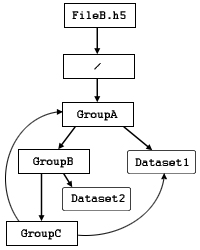

## TIFF

TIFF (Tag Image File Format) is a *flexible* raster container widely used in biosciences, remote sensing and GIS. 

A **GeoTIFF** is simply a TIFF that stores additional additional georeferencing information tags (CRS, affine transform, etc.) so geospatial software knows where each pixel sits on Earth. 

* **Images (“IFDs”)** – each “page” in a TIFF holds a 2-D array of pixels.  

  Multi-band rasters (e.g. RGB, multi-spectral) appear as *separate* IFDs or as extra samples within one IFD.

* **Tags** – key–value metadata pairs (datatype, compression, nodata value, CRS, resolution, etc.).  
  
  GeoTIFF adds standardised tags like ModelPixelScaleTag, ModelTiepointTag, GeoKeyDirectoryTag.

* **Compression / tiling** – DEFLATE, LZW, etc. Tiling lets software fetch small windows efficiently.

### Practical notes for xarray users

* **Read** – use `rioxarray.open_rasterio()` (wraps rasterio) to get an immediate, Dask-chunked DataArray.

* **Write** – `DataArray.rio.to_raster("out.tif")`; choose compression + tiling via driver_kwargs.

* **Dimensionality** – TIFF is inherently 2-D per band; no native time or vertical axis. If you need 4-D data, NetCDF or Zarr is usually a better fit.

* **Metadata depth** – single-level tags only (no nested groups). For rich hierarchies, stick to HDF5 / NetCDF-4.

* **Cloud-optimized GeoTIFF (COG)** – same format, arranged so HTTP range requests can stream windows efficiently; xarray handles it transparently when rasterio is compiled with libcurl.


### How does TIFF relate to xarray?



## Mapping storage formats to one another

Note that while we have discussed mapping various file formats to the xarray data model, it is also possible to map different file formats to one another.

For example, the [VirtualiZarr](https://github.com/zarr-developers/VirtualiZarr) library maps a range of file formats (including HDF5 and TIFF) to the Zarr data model, to allow reading data from those formats via the zarr-python API.